In [8]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
import matplotlib.ticker as ticker


from tqdm import tqdm # progress bars :)
tqdm.pandas()

import mrcc
from mrcc.p_from_scaled_containment import compute_confidence_intervals, compute_confidence_interval_one_step

In [9]:
pd.__version__

'0.24.2'

In [4]:
protein_csv = "../gtdb95-evolpaths.pathcompare.protein-input.csv.gz"
dna_csv = "../gtdb95-evolpaths.pathcompare.dna-input.csv.gz"

fastani_csv = "../gtdb95-evolpaths.path-fastani.csv.gz"
comparem_csv = "../gtdb95-evolpaths.path-compareM.csv.gz"

In [5]:
# replace zeroes with np.nan
cols = ["jaccard", "anchor_containment", "max_containment"]

In [18]:
protDF = pd.read_csv(protein_csv, sep=",")
#protDF[cols] = protDF[cols].replace({0:np.nan})
#protDF.head()

In [19]:
dnaDF = pd.read_csv(dna_csv, sep=",")
#dnaDF[cols] = dnaDF[cols].replace({0:np.nan})
#dnaDF.head()

In [48]:
def similarity_to_evoldist(similarity, ksize, b1=1.0, b2=1.0, return_ANI=False):
    # orig used with jaccard; trying with jaccard, max containment, anchor containment
    # proportion of observed differences
    if similarity == 0:
        return np.nan # 1.0
    p = 1 - np.power(2*similarity/(similarity + 1),(1/float(ksize)))
    # corrected evolutionary distance
    d = -(b1*np.log((1-p)/b2))
    if return_ANI:
        return 1-d
    return d

def mashdist_ANI(row):
    row['mash_jaccard_ANI'] = similarity_to_evoldist(row["jaccard"], row["ksize"], return_ANI=True)
    #row[mc_name] = similarity_to_evoldist(row["max_containment"], row["ksize"], return_ANI=True)
    #row[ac_name] = similarity_to_evoldist(row["anchor_containment"], row["ksize"], return_ANI=True)
    return row

In [50]:
dnaDF = dnaDF.progress_apply(mashdist_ANI, axis=1)
dnaDF.head()

100%|██████████| 230646/230646 [00:47<00:00, 4895.62it/s]


,comparison_name,anchor_name,ref_name,path,lowest_common_rank,alphabet,ksize,scaled,jaccard,max_containment,anchor_containment,anchor_hashes,query_hashes,num_common,alpha-ksize,mash_jaccard_ANI
0,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,21,100,0.160974,0.412247,0.412247,1829,3609,754,DNA-21,0.938923
1,GCA_004524385.1_x_GCA_004375715.1,GCA_004524385.1,GCA_004375715.1,path1,family,DNA,21,100,0.000201,0.000547,0.000547,1829,3157,1,DNA-21,0.627560
2,GCA_004524385.1_x_GCA_004524545.1,GCA_004524385.1,GCA_004524545.1,path1,order,DNA,21,100,0.000000,0.000000,0.000000,1829,2542,0,DNA-21,NaN
3,GCA_004524385.1_x_GCA_005191425.1,GCA_004524385.1,GCA_005191425.1,path1,class,DNA,21,100,0.000373,0.001093,0.001093,1829,3542,2,DNA-21,0.657025
4,GCA_004524385.1_x_GCA_001940645.1,GCA_004524385.1,GCA_001940645.1,path1,phylum,DNA,21,100,0.000000,0.000000,0.000000,1829,5537,0,DNA-21,NaN


In [20]:
# function run p_from_scaled_containment on full dataframe
def mrcc_maxcontain_one_step(row, confidence=0.95, return_ANI=False):
    scaled_perc = 1/row["scaled"]
    mc = row["anchor_containment"]
    num_kmers = row['anchor_hashes']*row['scaled']
    ksize = row["ksize"]
    mc_results = compute_confidence_interval_one_step([mc], num_kmers, ksize, confidence, scaled_perc)[0]
    pLow,pHigh,ptEst,pMid = mc_results[4:]
    if return_ANI:
        row["ac_ANILow"] = 1 - pLow
        row["ac_ANIHigh"] = 1- pHigh
        row['ac_ANIMid'] = 1 - pMid
        row['ac_ANIEst'] = 1 - ptEst
    else:
        row["ac_pLow"] = pLow
        row["ac_pHigh"] = pHigh
        row['ac_pMid'] = pMid
        row['ac_pEst'] = ptEst
    return row
#fullDF = simDF.appl y(mrcc_maxcontain, axis=1)

In [51]:
# to run p_from_scaled_containment on full dataframe
dnaDF = dnaDF.progress_apply(mrcc_maxcontain_one_step, axis=1, return_ANI=True) # with tqdm progress bar!
dnaDF.head()

100%|██████████| 230646/230646 [23:37<00:00, 162.69it/s]


,comparison_name,anchor_name,ref_name,path,lowest_common_rank,alphabet,ksize,scaled,jaccard,max_containment,anchor_containment,anchor_hashes,query_hashes,num_common,alpha-ksize,mash_jaccard_ANI,ac_ANILow,ac_ANIHigh,ac_ANIMid,ac_ANIEst
0,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,21,100,0.160974,0.412247,0.412247,1829,3609,754,DNA-21,0.938923,0.961331,0.955932,0.958631,0.958681
1,GCA_004524385.1_x_GCA_004375715.1,GCA_004524385.1,GCA_004375715.1,path1,family,DNA,21,100,0.000201,0.000547,0.000547,1829,3157,1,DNA-21,0.627560,0.760951,0.643099,0.702025,0.699289
2,GCA_004524385.1_x_GCA_004524545.1,GCA_004524385.1,GCA_004524545.1,path1,order,DNA,21,100,0.000000,0.000000,0.000000,1829,2542,0,DNA-21,NaN,0.000000,0.000000,0.000000,0.000000
3,GCA_004524385.1_x_GCA_005191425.1,GCA_004524385.1,GCA_005191425.1,path1,class,DNA,21,100,0.000373,0.001093,0.001093,1829,3542,2,DNA-21,0.657025,0.769926,0.678812,0.724369,0.722755
4,GCA_004524385.1_x_GCA_001940645.1,GCA_004524385.1,GCA_001940645.1,path1,phylum,DNA,21,100,0.000000,0.000000,0.000000,1829,5537,0,DNA-21,NaN,0.000000,0.000000,0.000000,0.000000


In [59]:
fulldnaDF.tail()

,comparison_name,anchor_name,ref_name,path,lowest_common_rank,alphabet,ksize,scaled,jaccard,max_containment,anchor_containment,anchor_hashes,query_hashes,num_common,alpha-ksize,ac_ANILow,ac_ANIHigh,ac_ANIMid,ac_ANIEst
230641,GCA_004376785.1_x_GCA_001303785.1,GCA_004376785.1,GCA_001303785.1,path2957,family,hp,35,100,0.004162,0.009712,0.009712,37686,50621,366,hp-35,0.878703,0.873270,0.875986,0.875980
230642,GCA_004376785.1_x_GCA_003645615.1,GCA_004376785.1,GCA_003645615.1,path2957,order,hp,35,100,0.000820,0.001778,0.001778,37686,44125,67,hp-35,0.840495,0.828563,0.834529,0.834499
230643,GCA_004376785.1_x_GCA_002347155.1,GCA_004376785.1,GCA_002347155.1,path2957,class,hp,35,100,0.000151,0.000451,0.000451,37686,75026,17,hp-35,0.813755,0.791319,0.802537,0.802431
230644,GCA_004376785.1_x_GCA_002774315.1,GCA_004376785.1,GCA_002774315.1,path2957,phylum,hp,35,100,0.000235,0.000575,0.000398,37686,26095,15,hp-35,0.811562,0.787807,0.799685,0.799567
230645,GCA_004376785.1_x_GCF_004358185.1,GCA_004376785.1,GCF_004358185.1,path2957,superkingdom,hp,35,100,0.000069,0.000239,0.000239,37686,93356,9,hp-35,0.803137,0.773197,0.788167,0.787982


In [60]:
dnaDF.to_csv("../gtdb95-evolpaths.pathcompare.dna.mrcc-onestep.csv.gz", index=False)

In [61]:
faDF = pd.read_csv(fastani_csv, sep=",")
faDF.head()

,comparison_name,anchor_name,ref_name,path,lowest_common_rank,fastani_ident,num_bidirectional_fragment_mappings,total_query_fragments
0,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,94.634,427.0,487.0
1,GCA_004524385.1_x_GCA_004375715.1,GCA_004524385.1,GCA_004375715.1,path1,family,NaN,NaN,NaN
2,GCA_004524385.1_x_GCA_004524545.1,GCA_004524385.1,GCA_004524545.1,path1,order,NaN,NaN,NaN
3,GCA_004524385.1_x_GCA_005191425.1,GCA_004524385.1,GCA_005191425.1,path1,class,NaN,NaN,NaN
4,GCA_004524385.1_x_GCA_004524545.1,GCA_004524385.1,GCA_004524545.1,path1,order,NaN,NaN,NaN


In [62]:
# colors, etc
rankorder = ["genus", "family", "order", "class", "phylum", "superkingdom"]
reverse_rankorder = rankorder[::-1]
nucl_order = ["nucleotide-21", "nucleotide-31", "nucleotide-51"]
dna_order=["DNA-21","DNA-31", "DNA-51"]
protein_order = ["protein-7", "protein-9", "protein-10", "protein-11"]
dayhoff_order = ["dayhoff-15", "dayhoff-17", "dayhoff-19"]
hp_order = ["hp-30", "hp-33", "hp-35"]

all_protein_order = protein_order + dayhoff_order + hp_order
alphak_order = nucl_order + protein_order + dayhoff_order + hp_order

alphabet_colors = {"nucleotide":"#b2182b", "protein": "#2166ac", "dayhoff": "#4393c3", "hp": "#92c5de"}
alphabet_order = ["nucleotide", "protein", "dayhoff", "hp"]
protnucl_colors = {"nucleotide":"#b2182b", "protein": "#2166ac"}
protnucl_order = ["nucleotide", "protein"]

pnlong_colors = {"nucleotide-21":"#b2182b","nucleotide-31":"#d6604d","nucleotide-51":"#f4a582", "protein-10": "#2166ac"}
pnlong_colors2 = {"nucleotide-21":"#b2182b","nucleotide-31":"#d6604d","nucleotide-51":"#f4a582", "protein-7": "#2166ac"}
pd_colors = {"DNA-21":"#b2182b","DNA-31":"#d6604d","DNA-51":"#f4a582", "protein-10": "#2166ac"}

alphak_colors = {}
nucl_colors =  {"nucleotide-21":"#b2182b","nucleotide-31":"#d6604d","nucleotide-51":"#f4a582"}
protein_colors = {"protein-7": "#a1d99b", "protein-9": "#74c476", "protein-10": "#31a354", "protein-11": "#006d2c"} 
dayhoff_colors = {"dayhoff-15": "#9e9ac8", "dayhoff-17": "#756bb1", "dayhoff-19": "#54278f"}
hp_colors = {"hp-30": "#6baed6", "hp-33": "#3182bd", "hp-35": "#08519c"}

alphak_colors = nucl_colors
alphak_colors.update(protein_colors)
alphak_colors.update(dayhoff_colors)
alphak_colors.update(hp_colors)

rankcolors = {"superkingdom": "#ffc000", "phylum": "#00b300", "class": "#329932", "order": "#2b9d91", "family": "#1c8cc3", "genus": "#074191"}

In [63]:
dna_only = dnaDF[dnaDF["alpha-ksize"].isin(dna_order)]
dna_only = dna_only[dna_only["num_common"] != 0]
dna_only.shape

(20835, 20)

In [64]:
dna_only.head()

,comparison_name,anchor_name,ref_name,path,lowest_common_rank,alphabet,ksize,scaled,jaccard,max_containment,anchor_containment,anchor_hashes,query_hashes,num_common,alpha-ksize,mash_jaccard_ANI,ac_ANILow,ac_ANIHigh,ac_ANIMid,ac_ANIEst
0,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,21,100,0.160974,0.412247,0.412247,1829,3609,754,DNA-21,0.938923,0.961331,0.955932,0.958631,0.958681
1,GCA_004524385.1_x_GCA_004375715.1,GCA_004524385.1,GCA_004375715.1,path1,family,DNA,21,100,0.000201,0.000547,0.000547,1829,3157,1,DNA-21,0.627560,0.760951,0.643099,0.702025,0.699289
3,GCA_004524385.1_x_GCA_005191425.1,GCA_004524385.1,GCA_005191425.1,path1,class,DNA,21,100,0.000373,0.001093,0.001093,1829,3542,2,DNA-21,0.657025,0.769926,0.678812,0.724369,0.722755
6,GCA_004375715.1_x_GCA_004524725.1,GCA_004375715.1,GCA_004524725.1,path2,genus,DNA,21,100,0.000539,0.001241,0.000950,3157,2417,3,DNA-21,0.674566,0.756785,0.681331,0.719058,0.717940
7,GCA_004375715.1_x_GCA_004524535.1,GCA_004375715.1,GCA_004524535.1,path2,family,DNA,21,100,0.000592,0.001267,0.001267,3157,3609,4,DNA-21,0.679037,0.762253,0.695187,0.728720,0.727842


In [65]:
faDF.groupby("lowest_common_rank")["fastani_ident"].describe()

,count,mean,std,min,25%,50%,75%,max
lowest_common_rank,,,,,,,,
class,142.0,76.248296,0.341534,75.3277,76.043650,76.2791,76.502075,76.9201
family,540.0,78.252356,1.209404,75.6251,77.480775,78.0287,78.689000,85.9324
genus,2250.0,82.867456,5.048807,76.2056,78.991675,81.1279,85.602525,99.8326
order,276.0,77.073519,0.665051,75.0543,76.728700,77.0776,77.442500,79.2195
phylum,2.0,74.991000,0.247063,74.8163,74.903650,74.9910,75.078350,75.1657
superkingdom,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
dna_only.groupby("lowest_common_rank")["ac_ANIEst"].describe()

,count,mean,std,min,25%,50%,75%,max
lowest_common_rank,,,,,,,,
class,1963.0,0.742330,0.059202,0.638586,0.693070,0.729016,0.777936,0.926822
family,5683.0,0.786015,0.055464,0.652373,0.745440,0.784032,0.831828,0.937120
genus,8023.0,0.855859,0.058871,0.666444,0.814173,0.860916,0.897595,0.992697
order,3232.0,0.755041,0.060136,0.638742,0.702319,0.755615,0.790597,0.910057
phylum,1345.0,0.720972,0.056350,0.648605,0.683705,0.700316,0.733269,0.924476
superkingdom,589.0,0.689390,0.030070,0.642958,0.672446,0.681315,0.695907,0.862773


In [68]:
dna_only.groupby("lowest_common_rank")["mash_jaccard_ANI"].describe()

,count,mean,std,min,25%,50%,75%,max
lowest_common_rank,,,,,,,,
class,1963.0,0.699341,0.079125,0.570225,0.627493,0.687759,0.749998,0.921266
family,5683.0,0.755060,0.071599,0.578704,0.704970,0.755577,0.815393,0.933057
genus,8023.0,0.841616,0.069836,0.597650,0.794155,0.849705,0.891616,0.991856
order,3232.0,0.714947,0.078887,0.565117,0.645953,0.721852,0.763990,0.912603
phylum,1345.0,0.672017,0.073981,0.562139,0.620630,0.645350,0.693144,0.918461
superkingdom,589.0,0.627011,0.038063,0.573967,0.605530,0.615593,0.634250,0.841497


In [39]:
dna_only[dna_only["ksize"] == 21].groupby("lowest_common_rank")["ac_ANIEst"].describe()

,count,mean,std,min,25%,50%,75%,max
lowest_common_rank,,,,,,,,
class,1194.0,0.702534,0.027030,0.638586,0.681292,0.698546,0.721559,0.830721
family,2567.0,0.741238,0.037797,0.652373,0.712385,0.740086,0.768148,0.873107
genus,2926.0,0.822716,0.062799,0.666444,0.776783,0.816939,0.864456,0.985790
order,1781.0,0.711216,0.032416,0.638742,0.686451,0.707134,0.733218,0.817859
phylum,1045.0,0.694387,0.020515,0.648605,0.678793,0.692845,0.706954,0.811273
superkingdom,542.0,0.682014,0.015766,0.642958,0.671224,0.679817,0.692207,0.745161


In [69]:
dna_only[dna_only["ksize"] == 31].groupby("lowest_common_rank")["ac_ANIEst"].describe()

,count,mean,std,min,25%,50%,75%,max
lowest_common_rank,,,,,,,,
class,483.0,0.775845,0.015225,0.739770,0.765154,0.773086,0.786345,0.880099
family,1851.0,0.796426,0.023284,0.739768,0.779546,0.794545,0.811110,0.893717
genus,2749.0,0.855294,0.048843,0.755070,0.818892,0.849426,0.887610,0.988019
order,879.0,0.779662,0.016698,0.738064,0.767296,0.777779,0.790329,0.874526
phylum,150.0,0.775009,0.018966,0.738376,0.762545,0.771987,0.784042,0.868467
superkingdom,44.0,0.768975,0.012701,0.738376,0.762242,0.768637,0.774969,0.797549


In [70]:
dna_only[dna_only["ksize"] == 51].groupby("lowest_common_rank")["ac_ANIEst"].describe()

,count,mean,std,min,25%,50%,75%,max
lowest_common_rank,,,,,,,,
class,286.0,0.851875,0.009830,0.836272,0.846122,0.849892,0.855163,0.926822
family,1265.0,0.861643,0.013422,0.831420,0.851526,0.859580,0.869793,0.937120
genus,2348.0,0.897823,0.031719,0.837221,0.874041,0.892334,0.918335,0.992697
order,572.0,0.853661,0.009579,0.831484,0.847392,0.851607,0.859009,0.910057
phylum,150.0,0.852149,0.010677,0.831166,0.847171,0.851579,0.855909,0.924476
superkingdom,3.0,0.854635,0.009688,0.843918,0.850566,0.857214,0.859993,0.862773


In [71]:
# merge dna, fastani 
alldna = pd.merge(dna_only, faDF, on = ["comparison_name", "path", "lowest_common_rank"])#, "anchor_name", "ref_name"])
alldna.head()

,comparison_name,anchor_name_x,ref_name_x,path,lowest_common_rank,alphabet,ksize,scaled,jaccard,max_containment,...,mash_jaccard_ANI,ac_ANILow,ac_ANIHigh,ac_ANIMid,ac_ANIEst,anchor_name_y,ref_name_y,fastani_ident,num_bidirectional_fragment_mappings,total_query_fragments
0,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,21,100,0.160974,0.412247,...,0.938923,0.961331,0.955932,0.958631,0.958681,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0
1,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,31,100,0.115089,0.307900,...,0.949102,0.965042,0.960318,0.962680,0.962714,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0
2,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,51,100,0.077937,0.215334,...,0.962083,0.972263,0.968376,0.970320,0.970340,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0
3,GCA_004524385.1_x_GCA_004375715.1,GCA_004524385.1,GCA_004375715.1,path1,family,DNA,21,100,0.000201,0.000547,...,0.627560,0.760951,0.643099,0.702025,0.699289,GCA_004524385.1,GCA_004375715.1,NaN,NaN,NaN
4,GCA_004524385.1_x_GCA_005191425.1,GCA_004524385.1,GCA_005191425.1,path1,class,DNA,21,100,0.000373,0.001093,...,0.657025,0.769926,0.678812,0.724369,0.722755,GCA_004524385.1,GCA_005191425.1,NaN,NaN,NaN


In [73]:
#rename cols as needed
#rename_vals = {"jaccard_ANI":"mash-jaccard-ANI", "acANIEst":"mrcc-contain-ANI"}#, "fastani_ident": "fastANI"}
#alldna.rename(columns=rename_vals, inplace=True)
alldna["fastANI"] = alldna["fastani_ident"]/100

alldna.head()

,comparison_name,anchor_name_x,ref_name_x,path,lowest_common_rank,alphabet,ksize,scaled,jaccard,max_containment,...,ac_ANILow,ac_ANIHigh,ac_ANIMid,ac_ANIEst,anchor_name_y,ref_name_y,fastani_ident,num_bidirectional_fragment_mappings,total_query_fragments,fastANI
0,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,21,100,0.160974,0.412247,...,0.961331,0.955932,0.958631,0.958681,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634
1,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,31,100,0.115089,0.307900,...,0.965042,0.960318,0.962680,0.962714,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634
2,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,51,100,0.077937,0.215334,...,0.972263,0.968376,0.970320,0.970340,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634
3,GCA_004524385.1_x_GCA_004375715.1,GCA_004524385.1,GCA_004375715.1,path1,family,DNA,21,100,0.000201,0.000547,...,0.760951,0.643099,0.702025,0.699289,GCA_004524385.1,GCA_004375715.1,NaN,NaN,NaN,NaN
4,GCA_004524385.1_x_GCA_005191425.1,GCA_004524385.1,GCA_005191425.1,path1,class,DNA,21,100,0.000373,0.001093,...,0.769926,0.678812,0.724369,0.722755,GCA_004524385.1,GCA_005191425.1,NaN,NaN,NaN,NaN


In [77]:
alldna_melt=pd.melt(alldna,id_vars=["comparison_name", "path", "lowest_common_rank"],
                     value_vars=["mash_jaccard_ANI", "ac_ANIEst", "fastANI"],
                     var_name='estimator', value_name='ANI')
alldna_melt.head()

,comparison_name,path,lowest_common_rank,estimator,ANI
0,GCA_004524385.1_x_GCA_004524535.1,path1,genus,mash_jaccard_ANI,0.938923
1,GCA_004524385.1_x_GCA_004524535.1,path1,genus,mash_jaccard_ANI,0.949102
2,GCA_004524385.1_x_GCA_004524535.1,path1,genus,mash_jaccard_ANI,0.962083
3,GCA_004524385.1_x_GCA_004375715.1,path1,family,mash_jaccard_ANI,0.627560
4,GCA_004524385.1_x_GCA_005191425.1,path1,class,mash_jaccard_ANI,0.657025


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

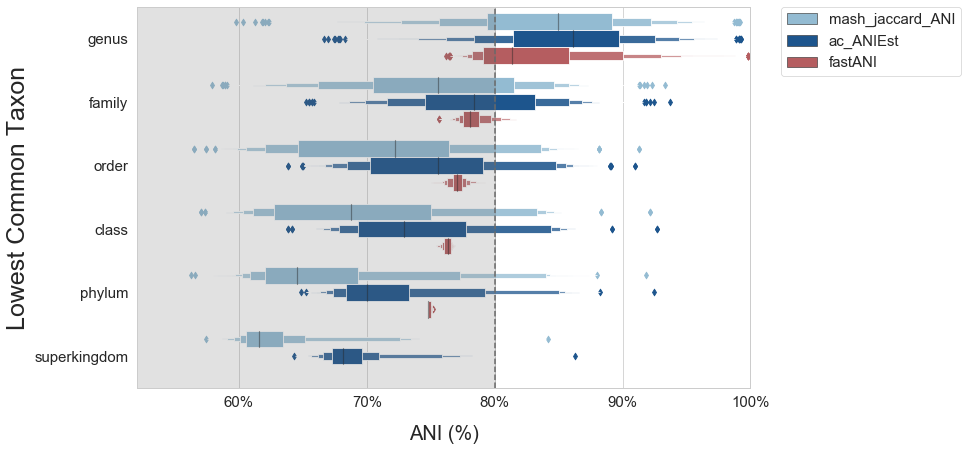

In [79]:
ani_colors = {"mash_jaccard_ANI":"#89bedc", "ac_ANIEst":"#0b559f", "fastANI":"#c44e52"}
!mkdir -p figs
sns.set() # reset defaults
with sns.plotting_context("paper", font_scale=1.7,rc={"font.size":25,"axes.titlesize":20,"axes.labelsize":20}):
    sns.set_style("whitegrid")
    #g=sns.violinplot(data=allprot_melt, y="lowest_common_rank", x="AAI", hue="estimator", order=rankorder, dodge=True,inner=None, color=".8")
    g=sns.boxenplot(data=alldna_melt, y="lowest_common_rank", x="ANI", 
                     hue="estimator", order=rankorder, dodge=True, palette=ani_colors)
    lgd=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #g.legend_.remove()
    #x = plt.gca().axes.get_xlim()
    #median_width = 0.5
    #order = 3
    #for tick, text in zip(g.get_yticks(), g.get_yticklabels()):
    #    rank = text.get_text()
    #    median_val = allprot_melt.loc[allprot_melt["lowest_common_rank"] == rank].median()['AAI']
    #    g.plot([median_val, median_val],[tick-median_width/2, tick+median_width/2],lw=1.8, color='dimgray', zorder=order)
    #    order+=1
    
    # plot vertical line at 80% ANI    
    plt.axvline(x=0.8, lw=1.5, color='dimgray', ls="--")
    plt.axvspan(0, 0.8, alpha=0.2, color='dimgray')
    g.set(xlim=(0.52, 1))
    # format x ticks as %
    plt.gcf().set_size_inches(11, 7)
   # g.set(xlim=(0, 1))
    g.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    g.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    plt.xlabel("ANI (%)", size=20, labelpad=15)
    plt.ylabel("Lowest Common Taxon", size=25)
    #g.axis("off")
    #g.spines["right"].set_visible(False)
    #g.spines["top"].set_visible(False)
    #g.spines["left"].set_visible(False)
    #g.spines["bottom"].set_visible(False)
    fig = g.get_figure()
    #fig.savefig("figs/gtdb95-evolpaths.ANIcompare_with_mrcc.boxen.png",bbox_inches='tight')
    fig.savefig("figs/gtdb95-evolpaths.ANIcompare_with_mrcc.boxen.pdf",bbox_inches='tight')

In [83]:
dnaB =pd.melt(alldna,id_vars=["comparison_name", "path", "fastani_ident"],
                     value_vars=["mash_jaccard_ANI", "ac_ANIEst"],
                     var_name='estimator', value_name='ANI')

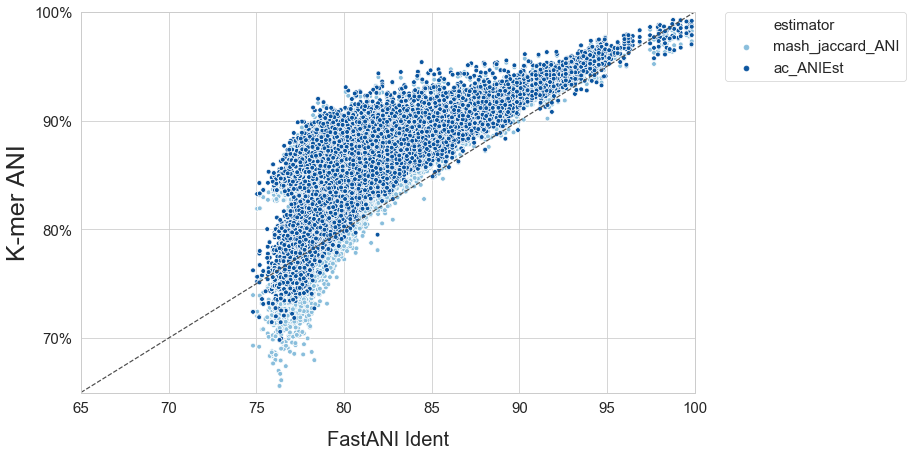

In [84]:
ani_colors = {"mash_jaccard_ANI":"#89bedc", "ac_ANIEst":"#0b559f", "fastANI":"#c44e52"}

sns.set() # reset defaults
with sns.plotting_context("paper", font_scale=1.7,rc={"font.size":25,"axes.titlesize":20,"axes.labelsize":20}):
    sns.set_style("whitegrid")
    g=sns.scatterplot(data=dnaB, x="fastani_ident", y="ANI", hue="estimator", palette=ani_colors)
                     #, order=rankorder, dodge=True, )
    lgd=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.gcf().set_size_inches(11, 7)
    g.set(xlim=(65, 100), ylim=(0.65, 1))
    g.plot(g.get_xlim(), g.get_ylim(), ls="--", c=".3")
    g.xaxis.set_major_locator(ticker.MultipleLocator(5))
    g.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    g.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    plt.xlabel("FastANI Ident", size=20, labelpad=15)
    plt.ylabel("K-mer ANI", size=25)
    fig = g.get_figure()

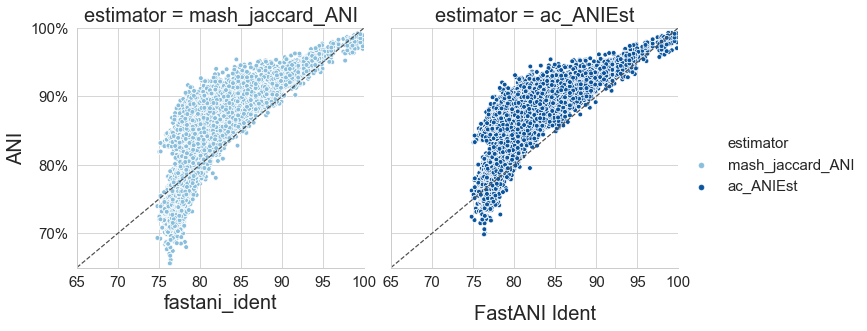

In [85]:
ani_colors = {"mash_jaccard_ANI":"#89bedc", "ac_ANIEst":"#0b559f", "fastANI":"#c44e52"}

sns.set() # reset defaults
with sns.plotting_context("paper", font_scale=1.7,rc={"font.size":25,"axes.titlesize":20,"axes.labelsize":20}):
    sns.set_style("whitegrid")
    g=sns.relplot(data=dnaB, x="fastani_ident", y="ANI", hue="estimator",col="estimator", palette=ani_colors)
                     #, order=rankorder, dodge=True, )
    #lgd=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.gcf().set_size_inches(11, 7)
    #g.set(xlim=(65, 100), ylim=(0.65, 1))
    xlim=(65, 100)#None
    ylim= (0.65, 1)
    for ax in g.fig.axes:
        ax.set(xlim=xlim, ylim=ylim)
        ax.plot(xlim, ylim, ls="--", c=".3")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    plt.xlabel("FastANI Ident", size=20, labelpad=15)
    plt.ylabel("K-mer ANI", size=25)
    #fig = g.get_figure()

In [87]:
dnaC =pd.melt(alldna,id_vars=["comparison_name", "path", "mash_jaccard_ANI"],
                     value_vars=["ac_ANIEst"],
                     var_name='estimator', value_name='ANI')

In [90]:
dnaC.head()

,comparison_name,path,mash_jaccard_ANI,estimator,ANI
0,GCA_004524385.1_x_GCA_004524535.1,path1,0.938923,ac_ANIEst,0.958681
1,GCA_004524385.1_x_GCA_004524535.1,path1,0.949102,ac_ANIEst,0.962714
2,GCA_004524385.1_x_GCA_004524535.1,path1,0.962083,ac_ANIEst,0.970340
3,GCA_004524385.1_x_GCA_004375715.1,path1,0.627560,ac_ANIEst,0.699289
4,GCA_004524385.1_x_GCA_005191425.1,path1,0.657025,ac_ANIEst,0.722755


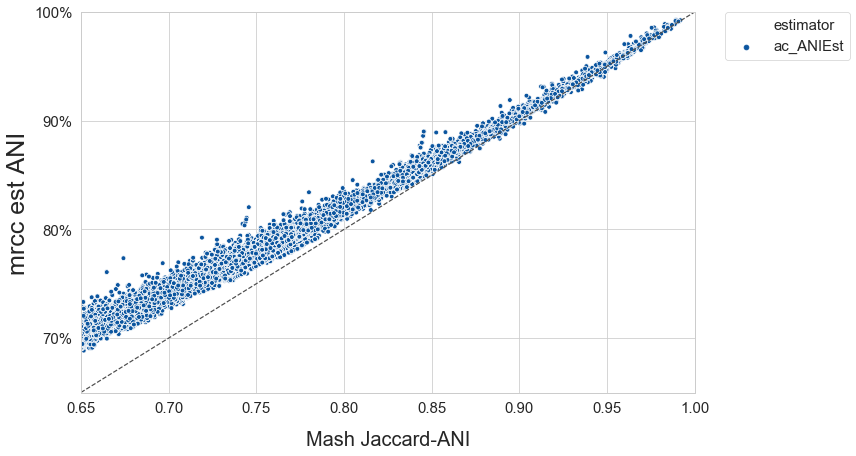

In [102]:
ani_colors = {"mash_jaccard_ANI":"#89bedc", "ac_ANIEst":"#0b559f", "fastANI":"#c44e52"}

sns.set() # reset defaults
with sns.plotting_context("paper", font_scale=1.7,rc={"font.size":25,"axes.titlesize":20,"axes.labelsize":20}):
    sns.set_style("whitegrid")
    g=sns.scatterplot(data=dnaC, x="mash_jaccard_ANI", y="ANI", hue="estimator", palette=ani_colors)
                     #, order=rankorder, dodge=True, )
    lgd=g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.gcf().set_size_inches(11, 7)
    g.set(xlim=(0.65, 1), ylim=(0.65, 1))
    g.plot(g.get_xlim(), g.get_ylim(), ls="--", c=".3")
    g.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    g.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    g.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))

    plt.xlabel("Mash Jaccard-ANI", size=20, labelpad=15)
    plt.ylabel("mrcc est ANI", size=25)
    fig = g.get_figure()

In [105]:
dnaC['ANI-diff'] = dnaC['ANI'] - dnaC['mash_jaccard_ANI']
dnaC.head()

,comparison_name,path,mash_jaccard_ANI,estimator,ANI,ANI-diff
0,GCA_004524385.1_x_GCA_004524535.1,path1,0.938923,ac_ANIEst,0.958681,0.019759
1,GCA_004524385.1_x_GCA_004524535.1,path1,0.949102,ac_ANIEst,0.962714,0.013612
2,GCA_004524385.1_x_GCA_004524535.1,path1,0.962083,ac_ANIEst,0.970340,0.008256
3,GCA_004524385.1_x_GCA_004375715.1,path1,0.627560,ac_ANIEst,0.699289,0.071729
4,GCA_004524385.1_x_GCA_005191425.1,path1,0.657025,ac_ANIEst,0.722755,0.065730


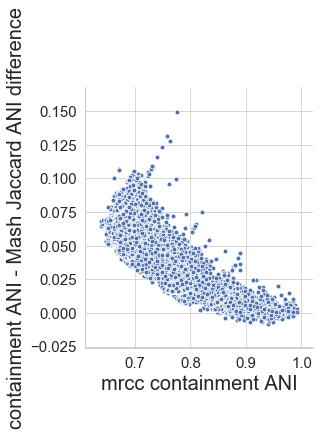

In [114]:
sns.set() # reset defaults
with sns.plotting_context("paper", font_scale=1.7,rc={"font.size":25,"axes.titlesize":20,"axes.labelsize":20}):
    sns.set_style("whitegrid")
    g=sns.relplot(data=dnaC, x="ANI", y="ANI-diff")#, hue="estimator",col="estimator")
    xlim=(0, 1.009)#None
    ylim= (0, .2)
    #for ax in g.fig.axes:
        #ax.plot((0,1), (0,1), ls="--", c=".3")
        #ax.margins(x=0.1, y=0.1)
        #ax.axvspan(0, 0.5, alpha=0.2, color='dimgray')
        #ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        #ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        #ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
       # ax.set_title(ax.get_title(), pad=20)
        #ax.set(xlim=xlim, ylim=ylim)
    g.fig.tight_layout()

    #g.add_legend(bbox_to_anchor=(1.14, 1), loc=2, borderaxespad=0.)
    g.set_axis_labels("mrcc containment ANI", "containment ANI - Mash Jaccard ANI difference")#, size=20, labelpad=15)
    #g.savefig("gtdb95-evolpaths.AAI-concordance.png",bbox_inches='tight')

In [115]:
alldna.head()

,comparison_name,anchor_name_x,ref_name_x,path,lowest_common_rank,alphabet,ksize,scaled,jaccard,max_containment,...,ac_ANILow,ac_ANIHigh,ac_ANIMid,ac_ANIEst,anchor_name_y,ref_name_y,fastani_ident,num_bidirectional_fragment_mappings,total_query_fragments,fastANI
0,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,21,100,0.160974,0.412247,...,0.961331,0.955932,0.958631,0.958681,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634
1,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,31,100,0.115089,0.307900,...,0.965042,0.960318,0.962680,0.962714,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634
2,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,51,100,0.077937,0.215334,...,0.972263,0.968376,0.970320,0.970340,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634
3,GCA_004524385.1_x_GCA_004375715.1,GCA_004524385.1,GCA_004375715.1,path1,family,DNA,21,100,0.000201,0.000547,...,0.760951,0.643099,0.702025,0.699289,GCA_004524385.1,GCA_004375715.1,NaN,NaN,NaN,NaN
4,GCA_004524385.1_x_GCA_005191425.1,GCA_004524385.1,GCA_005191425.1,path1,class,DNA,21,100,0.000373,0.001093,...,0.769926,0.678812,0.724369,0.722755,GCA_004524385.1,GCA_005191425.1,NaN,NaN,NaN,NaN


In [116]:
alldna['ANI-diff'] = alldna['fastANI'] - alldna['ac_ANIEst']
alldna.head()

,comparison_name,anchor_name_x,ref_name_x,path,lowest_common_rank,alphabet,ksize,scaled,jaccard,max_containment,...,ac_ANIHigh,ac_ANIMid,ac_ANIEst,anchor_name_y,ref_name_y,fastani_ident,num_bidirectional_fragment_mappings,total_query_fragments,fastANI,ANI-diff
0,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,21,100,0.160974,0.412247,...,0.955932,0.958631,0.958681,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634,-0.012341
1,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,31,100,0.115089,0.307900,...,0.960318,0.962680,0.962714,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634,-0.016374
2,GCA_004524385.1_x_GCA_004524535.1,GCA_004524385.1,GCA_004524535.1,path1,genus,DNA,51,100,0.077937,0.215334,...,0.968376,0.970320,0.970340,GCA_004524385.1,GCA_004524535.1,94.634,427.0,487.0,0.94634,-0.024000
3,GCA_004524385.1_x_GCA_004375715.1,GCA_004524385.1,GCA_004375715.1,path1,family,DNA,21,100,0.000201,0.000547,...,0.643099,0.702025,0.699289,GCA_004524385.1,GCA_004375715.1,NaN,NaN,NaN,NaN,NaN
4,GCA_004524385.1_x_GCA_005191425.1,GCA_004524385.1,GCA_005191425.1,path1,class,DNA,21,100,0.000373,0.001093,...,0.678812,0.724369,0.722755,GCA_004524385.1,GCA_005191425.1,NaN,NaN,NaN,NaN,NaN


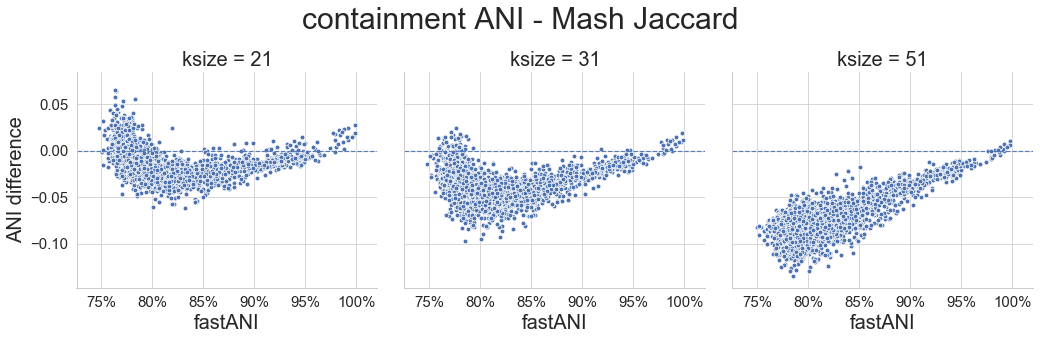

In [145]:
sns.set() # reset defaults
with sns.plotting_context("paper", font_scale=1.7,rc={"font.size":25,"axes.titlesize":20,"axes.labelsize":20}):
    sns.set_style("whitegrid")
    g=sns.relplot(data=alldna, x="fastANI", y="ANI-diff", col='ksize')#, hue="ksize")#,col="estimator")
    for ax in g.fig.axes:
        #ax.plot((0.7,0), (1,0), ls="--", c=".3")
        ax.axhline(0.0, alpha=0.9,  ls="--",)
        #ax.margins(x=0.1, y=0.1)
        #ax.axvspan(0, 0.5, alpha=0.2, color='dimgray')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        #ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
       # ax.set_title(ax.get_title(), pad=20)
        #ax.set(xlim=xlim, ylim=ylim)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle("containment ANI - Mash Jaccard")
    g.set_axis_labels("fastANI", "ANI difference")#, size=20, labelpad=15)

    #xlim=(0, 1.009)#None
    #ylim= (0, .2)